In [1]:
# Import Modules/Libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms, models
from torchvision.models import VGG16_Weights
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import matplotlib
from matplotlib import pyplot as plt
import os
import glob
from PIL import Image
import numpy as np
import random
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Set random seed for reproducibility
random_seed = 42
random.seed(random_seed)
torch.manual_seed(random_seed)

In [2]:
# Import Libraries and Setup GPU Device
# Confirm GPU device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [3]:
# Data Preparation and Transformations
# Define the transformations for the dataset
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images to 128x128
    transforms.RandomHorizontalFlip(p=0.5),  # Apply random horizontal flip
    transforms.RandomRotation(degrees=15),  # Apply random rotation within 15 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Randomly change brightness, contrast, etc.
    transforms.ToTensor(),          # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize the images
])

In [4]:
# Custom Dataset Class
# Create a custom dataset class to handle images without subfolders
class CatDogDataset(Dataset):
    def __init__(self, file_paths, transform=None):
        self.file_paths = file_paths
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        img_path = self.file_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = 0 if 'cat' in os.path.basename(img_path) else 1
        if self.transform:
            image = self.transform(image)
        return image, label

# Load all image paths from the 'dataset/train' directory
image_paths = glob.glob('dataset/train/*.jpg')

# Check if the dataset is loaded correctly
if len(image_paths) == 0:
    raise ValueError("No images found in the dataset/train directory. Please check the path and ensure images are available.")
else:
    print(f"Number of images found: {len(image_paths)}")

# Create dataset
full_dataset = CatDogDataset(image_paths, transform=transform)

# Split the dataset into 70% training and 30% testing
train_size = int(0.7 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size], generator=torch.Generator().manual_seed(random_seed))

# Create DataLoaders for training and testing
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False, num_workers=0)

Number of images found: 25000


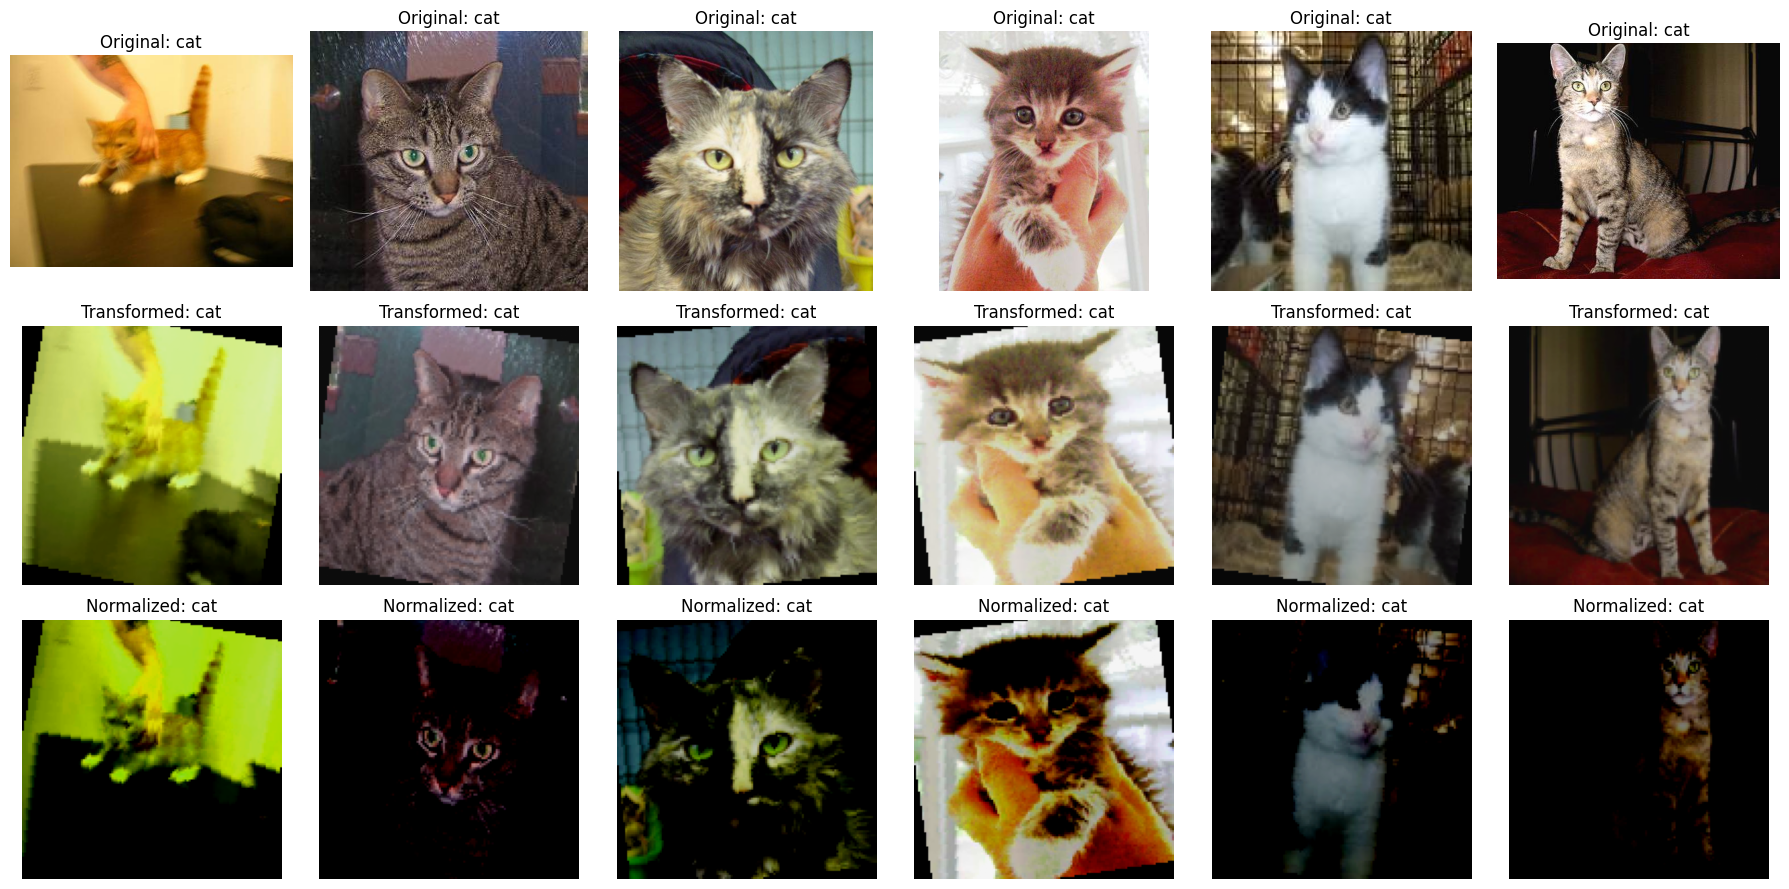

In [5]:
# Demonstrate Some Transformed Samples
# Display a few samples after transformations to verify the augmentation and normalization
def imshow(img, title=None):
    if img.min() < 0 or img.max() > 1:
        img = img / 2 + 0.5  # Unnormalize the image
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title:
        plt.title(title)

# Get some random training images
sample_loader = DataLoader(train_dataset, batch_size=6, shuffle=True)
dataiter = iter(sample_loader)
images, labels = next(dataiter)

# Show 6 random images: original, transformed, and normalized
fig, axes = plt.subplots(3, 6, figsize=(18, 9))

# Ensure consistent image paths and transformations
for i in range(6):
    img_path = image_paths[i]
    
    # Load the original image
    original_img = Image.open(img_path).convert('RGB')
    axes[0, i].imshow(original_img)
    axes[0, i].set_title(f"Original: {'cat' if 'cat' in img_path else 'dog'}")
    axes[0, i].axis('off')
    
    # Apply the same transformation used for training
    if transform:
        transformed_img_tensor = transform(original_img)
    
    # Transformed image (after augmentation)
    transformed_img = transformed_img_tensor.permute(1, 2, 0).numpy() * 0.5 + 0.5  # Reverse normalization for visualization
    transformed_img = np.clip(transformed_img, 0, 1)  # Clip values to [0, 1] range
    axes[1, i].imshow(transformed_img)
    axes[1, i].set_title(f"Transformed: {'cat' if 'cat' in img_path else 'dog'}")
    axes[1, i].axis('off')
    
    # Normalized image
    normalized_img = transformed_img_tensor.permute(1, 2, 0).numpy()
    normalized_img = np.clip(normalized_img, 0, 1)  # Clip values to [0, 1] range
    axes[2, i].imshow(normalized_img)
    axes[2, i].set_title(f"Normalized: {'cat' if 'cat' in img_path else 'dog'}")
    axes[2, i].axis('off')

plt.tight_layout()
plt.savefig('figures/sample_transforms_A.png')
plt.show()

In [6]:
# Initialize Pre-trained Model
# Load a pre-trained VGG16 model and modify it for binary classification
weights = VGG16_Weights.DEFAULT
model = models.vgg16(weights=weights)
# model = models.vgg16(pretrained=True)
for param in model.features.parameters():
    param.requires_grad = False  # Freeze the feature extraction layers
    
# # Freeze all layers first
# for param in model.parameters():
#     param.requires_grad = False
# 
# # Unfreeze the last 5 layers of the classifier
# for param in list(model.classifier.parameters())[-5:]:
#     param.requires_grad = True

# Modify the classifier to output 2 classes (cat and dog)
model.classifier[6] = nn.Linear(4096, 2)

# Move model to GPU if available
model = model.to(device)

C:\ProgramData\anaconda3\envs\detection_env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\ProgramData\anaconda3\envs\detection_env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
# Loss and Optimizer Setup
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

In [8]:
# Training Loop
# Training loop with model checkpointing to prevent data loss in case of interruption
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=10, checkpoint_path='models/checkpoint_model_A.pth'):
    model.train()
    train_losses, val_losses = [], []
    val_accuracies, val_f1_scores, val_aucs = [], [], []  # Initialize the lists for metrics

    # Load checkpoint if available
    start_epoch = 0
    if os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path, weights_only=False)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        train_losses = checkpoint['train_losses']
        val_losses = checkpoint['val_losses']
        val_accuracies = checkpoint.get('val_accuracies', [])
        val_f1_scores = checkpoint.get('val_f1_scores', [])
        val_aucs = checkpoint.get('val_aucs', [])
        print(f"Resuming training from epoch {start_epoch}")

    for epoch in range(start_epoch, num_epochs):
        running_loss = 0.0
        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        else:
            # Calculate average training loss
            train_losses.append(running_loss / len(train_loader))
            # Validate the model and calculate metrics
            val_loss, val_accuracy, val_f1, val_auc = validate_model(model, criterion, val_loader)
            val_losses.append(val_loss)
            val_accuracies.append(val_accuracy)
            val_f1_scores.append(val_f1)
            val_aucs.append(val_auc)

            # Print epoch details
            print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {running_loss/len(train_loader):.4f}, "
                  f"Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}, F1 Score: {val_f1:.4f}, AUC: {val_auc:.4f}")

            # Save checkpoint after each epoch
            if not os.path.exists(os.path.dirname(checkpoint_path)):
                os.makedirs(os.path.dirname(checkpoint_path))
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_losses': train_losses,
                'val_losses': val_losses,
                'val_accuracies': val_accuracies,
                'val_f1_scores': val_f1_scores,
                'val_aucs': val_aucs
            }, checkpoint_path)

    return train_losses, val_losses, val_accuracies, val_f1_scores, val_aucs

In [9]:
# Validation Loop: Calculate additional metrics
def validate_model(model, criterion, val_loader):
    model.eval()
    val_loss = 0.0
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc="Validation"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Collecting all labels and predictions for metrics calculation
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    auc = roc_auc_score(all_labels, all_preds)

    print(f"Validation Metrics - Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}, AUC: {auc:.4f}")
    
    return val_loss / len(val_loader), accuracy, f1, auc

In [10]:
# Training the Model
# Train the model and save progress periodically
train_losses, val_losses, val_accuracies, val_f1_scores, val_aucs = train_model(model, criterion, optimizer, train_loader, test_loader, num_epochs=50)

Validation: 100%|██████████| 30/30 [00:26<00:00,  1.14it/s]


Validation Metrics - Accuracy: 0.9416, F1 Score: 0.9416, AUC: 0.9417
Epoch 1/20, Train Loss: 0.5331, Validation Loss: 0.1450, Accuracy: 0.9416, F1 Score: 0.9416, AUC: 0.9417


Validation: 100%|██████████| 30/30 [00:25<00:00,  1.17it/s]


Validation Metrics - Accuracy: 0.9369, F1 Score: 0.9369, AUC: 0.9367
Epoch 2/20, Train Loss: 0.1402, Validation Loss: 0.1498, Accuracy: 0.9369, F1 Score: 0.9369, AUC: 0.9367


Validation: 100%|██████████| 30/30 [00:25<00:00,  1.16it/s]


Validation Metrics - Accuracy: 0.9427, F1 Score: 0.9426, AUC: 0.9425
Epoch 3/20, Train Loss: 0.1342, Validation Loss: 0.1372, Accuracy: 0.9427, F1 Score: 0.9426, AUC: 0.9425


Validation: 100%|██████████| 30/30 [00:26<00:00,  1.12it/s]


Validation Metrics - Accuracy: 0.9507, F1 Score: 0.9507, AUC: 0.9507
Epoch 4/20, Train Loss: 0.1282, Validation Loss: 0.1308, Accuracy: 0.9507, F1 Score: 0.9507, AUC: 0.9507


Validation: 100%|██████████| 30/30 [00:26<00:00,  1.14it/s]


Validation Metrics - Accuracy: 0.9465, F1 Score: 0.9465, AUC: 0.9466
Epoch 5/20, Train Loss: 0.1261, Validation Loss: 0.1277, Accuracy: 0.9465, F1 Score: 0.9465, AUC: 0.9466


Validation: 100%|██████████| 30/30 [00:25<00:00,  1.18it/s]


Validation Metrics - Accuracy: 0.9436, F1 Score: 0.9436, AUC: 0.9439
Epoch 6/20, Train Loss: 0.1081, Validation Loss: 0.1313, Accuracy: 0.9436, F1 Score: 0.9436, AUC: 0.9439


Validation: 100%|██████████| 30/30 [00:25<00:00,  1.18it/s]


Validation Metrics - Accuracy: 0.9419, F1 Score: 0.9418, AUC: 0.9422
Epoch 7/20, Train Loss: 0.1038, Validation Loss: 0.1549, Accuracy: 0.9419, F1 Score: 0.9418, AUC: 0.9422


Validation: 100%|██████████| 30/30 [00:25<00:00,  1.16it/s]


Validation Metrics - Accuracy: 0.9439, F1 Score: 0.9438, AUC: 0.9437
Epoch 8/20, Train Loss: 0.0981, Validation Loss: 0.1516, Accuracy: 0.9439, F1 Score: 0.9438, AUC: 0.9437


Validation: 100%|██████████| 30/30 [00:25<00:00,  1.17it/s]


Validation Metrics - Accuracy: 0.9460, F1 Score: 0.9460, AUC: 0.9458
Epoch 9/20, Train Loss: 0.0985, Validation Loss: 0.1350, Accuracy: 0.9460, F1 Score: 0.9460, AUC: 0.9458


Validation: 100%|██████████| 30/30 [00:25<00:00,  1.17it/s]


Validation Metrics - Accuracy: 0.9505, F1 Score: 0.9505, AUC: 0.9505
Epoch 10/20, Train Loss: 0.0913, Validation Loss: 0.1225, Accuracy: 0.9505, F1 Score: 0.9505, AUC: 0.9505


Validation: 100%|██████████| 30/30 [00:25<00:00,  1.16it/s]


Validation Metrics - Accuracy: 0.9467, F1 Score: 0.9467, AUC: 0.9467
Epoch 11/20, Train Loss: 0.0878, Validation Loss: 0.1293, Accuracy: 0.9467, F1 Score: 0.9467, AUC: 0.9467


Validation: 100%|██████████| 30/30 [00:25<00:00,  1.18it/s]


Validation Metrics - Accuracy: 0.9493, F1 Score: 0.9493, AUC: 0.9492
Epoch 12/20, Train Loss: 0.0869, Validation Loss: 0.1283, Accuracy: 0.9493, F1 Score: 0.9493, AUC: 0.9492


Validation: 100%|██████████| 30/30 [00:25<00:00,  1.18it/s]


Validation Metrics - Accuracy: 0.9516, F1 Score: 0.9516, AUC: 0.9517
Epoch 13/20, Train Loss: 0.0779, Validation Loss: 0.1314, Accuracy: 0.9516, F1 Score: 0.9516, AUC: 0.9517


Validation: 100%|██████████| 30/30 [00:25<00:00,  1.18it/s]


Validation Metrics - Accuracy: 0.9472, F1 Score: 0.9472, AUC: 0.9471
Epoch 14/20, Train Loss: 0.0704, Validation Loss: 0.1288, Accuracy: 0.9472, F1 Score: 0.9472, AUC: 0.9471


Validation: 100%|██████████| 30/30 [00:25<00:00,  1.17it/s]


Validation Metrics - Accuracy: 0.9507, F1 Score: 0.9507, AUC: 0.9506
Epoch 15/20, Train Loss: 0.0707, Validation Loss: 0.1345, Accuracy: 0.9507, F1 Score: 0.9507, AUC: 0.9506


Validation: 100%|██████████| 30/30 [00:25<00:00,  1.16it/s]


Validation Metrics - Accuracy: 0.9520, F1 Score: 0.9520, AUC: 0.9521
Epoch 16/20, Train Loss: 0.0600, Validation Loss: 0.1414, Accuracy: 0.9520, F1 Score: 0.9520, AUC: 0.9521


Validation: 100%|██████████| 30/30 [00:26<00:00,  1.14it/s]


Validation Metrics - Accuracy: 0.9469, F1 Score: 0.9469, AUC: 0.9469
Epoch 17/20, Train Loss: 0.0643, Validation Loss: 0.1424, Accuracy: 0.9469, F1 Score: 0.9469, AUC: 0.9469


Validation: 100%|██████████| 30/30 [00:25<00:00,  1.18it/s]


Validation Metrics - Accuracy: 0.9515, F1 Score: 0.9515, AUC: 0.9516
Epoch 18/20, Train Loss: 0.0653, Validation Loss: 0.1403, Accuracy: 0.9515, F1 Score: 0.9515, AUC: 0.9516


Validation: 100%|██████████| 30/30 [00:25<00:00,  1.17it/s]


Validation Metrics - Accuracy: 0.9460, F1 Score: 0.9460, AUC: 0.9459
Epoch 19/20, Train Loss: 0.0615, Validation Loss: 0.1537, Accuracy: 0.9460, F1 Score: 0.9460, AUC: 0.9459


Validation: 100%|██████████| 30/30 [00:25<00:00,  1.17it/s]


Validation Metrics - Accuracy: 0.9531, F1 Score: 0.9531, AUC: 0.9531
Epoch 20/20, Train Loss: 0.0638, Validation Loss: 0.1532, Accuracy: 0.9531, F1 Score: 0.9531, AUC: 0.9531


In [11]:
# Save the Final Model
# Save the final trained model
if not os.path.exists('models'):
    os.makedirs('models')
torch.save(model.state_dict(), 'models/classifier_model_A.pth')

Validation: 100%|██████████| 30/30 [00:26<00:00,  1.15it/s]

Validation Metrics - Accuracy: 0.9519, F1 Score: 0.9519, AUC: 0.9519
Loaded Model - Validation Loss: 0.1565, Accuracy: 0.9519, F1 Score: 0.9519, AUC: 0.9519
Loss plot saved as training_validation_loss_A.png
Metrics plot saved as validation_metrics_A.png


<Figure size 1000x500 with 0 Axes>

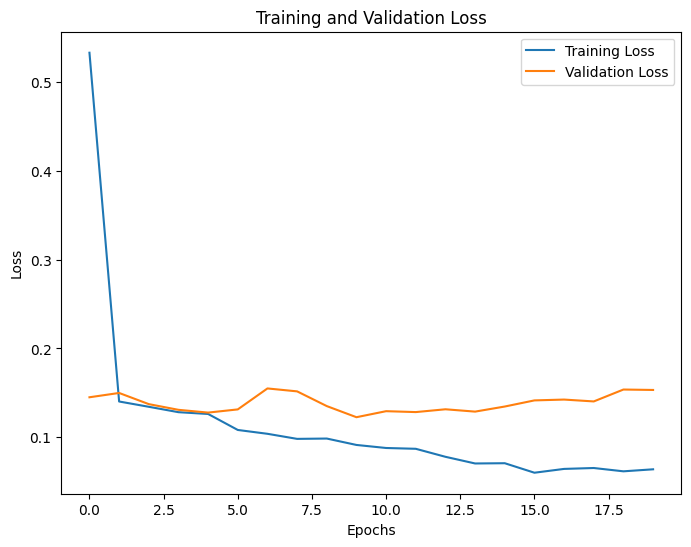

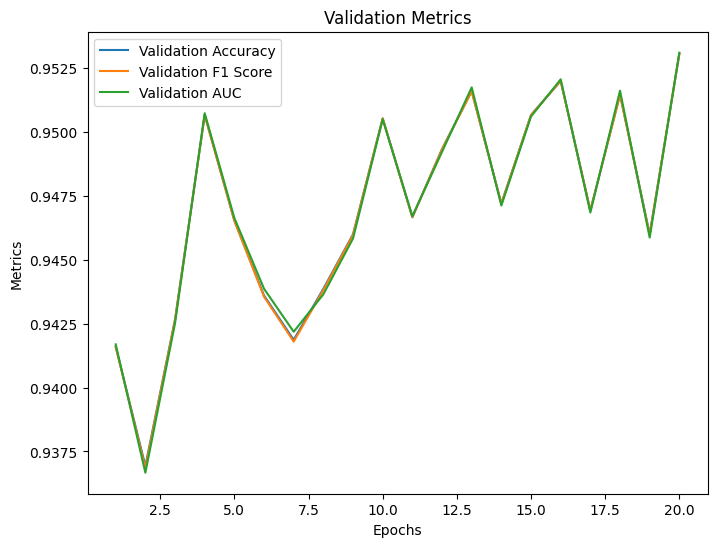

In [12]:
# Plotting Loss Curves
# Load model and evaluate metrics without retraining
checkpoint_path = 'models/checkpoint_model_A.pth'
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, weights_only=False)  # Load saved model
    model.load_state_dict(checkpoint['model_state_dict'])
    
    train_losses = checkpoint.get('train_losses', [])
    val_losses = checkpoint.get('val_losses', [])
    val_accuracies = checkpoint.get('val_accuracies', [])
    val_f1_scores = checkpoint.get('val_f1_scores', [])
    val_aucs = checkpoint.get('val_aucs', [])

    # Evaluate the model using validation dataset
    val_loss, val_accuracy, val_f1, val_auc = validate_model(model, criterion, test_loader)
    print(f"Loaded Model - Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}, F1 Score: {val_f1:.4f}, AUC: {val_auc:.4f}")
else:
    print("No saved model found.")

# Plotting Loss Curves and Metrics
if len(train_losses) > 0 and len(val_losses) > 0:
    plt.figure(figsize=(10, 5))
    
    # Plotting Loss
    plt.figure(figsize=(8, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.savefig('figures/training_validation_loss_A.png')
    print('Loss plot saved as training_validation_loss_A.png')

    # Plotting Metrics: Accuracy, F1, AUC
    plt.figure(figsize=(8, 6))
    epochs = list(range(1, len(val_accuracies) + 1))
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.plot(epochs, val_f1_scores, label='Validation F1 Score')
    plt.plot(epochs, val_aucs, label='Validation AUC')
    plt.xlabel('Epochs')
    plt.ylabel('Metrics')
    plt.legend()
    plt.title('Validation Metrics')
    plt.savefig('figures/validation_metrics_A.png')
    print('Metrics plot saved as validation_metrics_A.png')
else:
    print("No loss data to plot.")

Confusion Matrix Calculation: 100%|██████████| 30/30 [00:25<00:00,  1.16it/s]


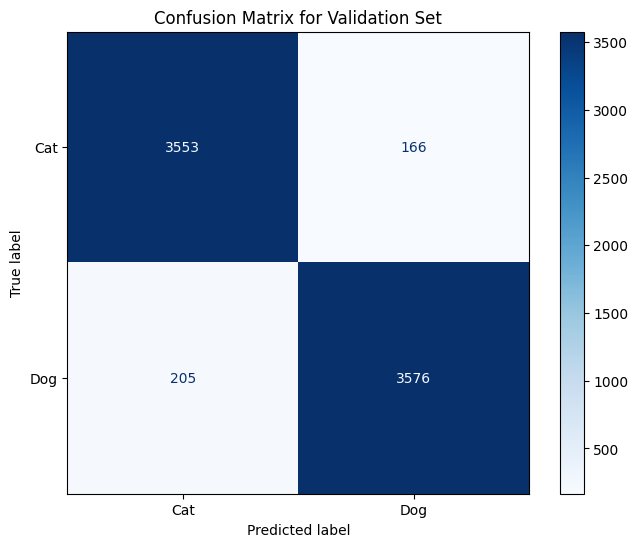

Confusion matrix saved as confusion_matrix_A.png


In [13]:
# Plot Confusion Matrix
# Function to plot and save confusion matrix
def plot_confusion_matrix(model, val_loader):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc="Confusion Matrix Calculation"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    # Generate confusion matrix
    cm = confusion_matrix(all_labels, all_preds, labels=[0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Cat', 'Dog'])
    
    # Plot and save confusion matrix
    fig, ax = plt.subplots(figsize=(8, 6))
    disp.plot(ax=ax, cmap='Blues')
    plt.title('Confusion Matrix for Validation Set')
    plt.savefig('figures/confusion_matrix_A.png')
    plt.show()
    print('Confusion matrix saved as confusion_matrix_A.png')

# Call the function after testing
plot_confusion_matrix(model, test_loader)

Finding Incorrect Predictions: 100%|██████████| 30/30 [00:25<00:00,  1.16it/s]


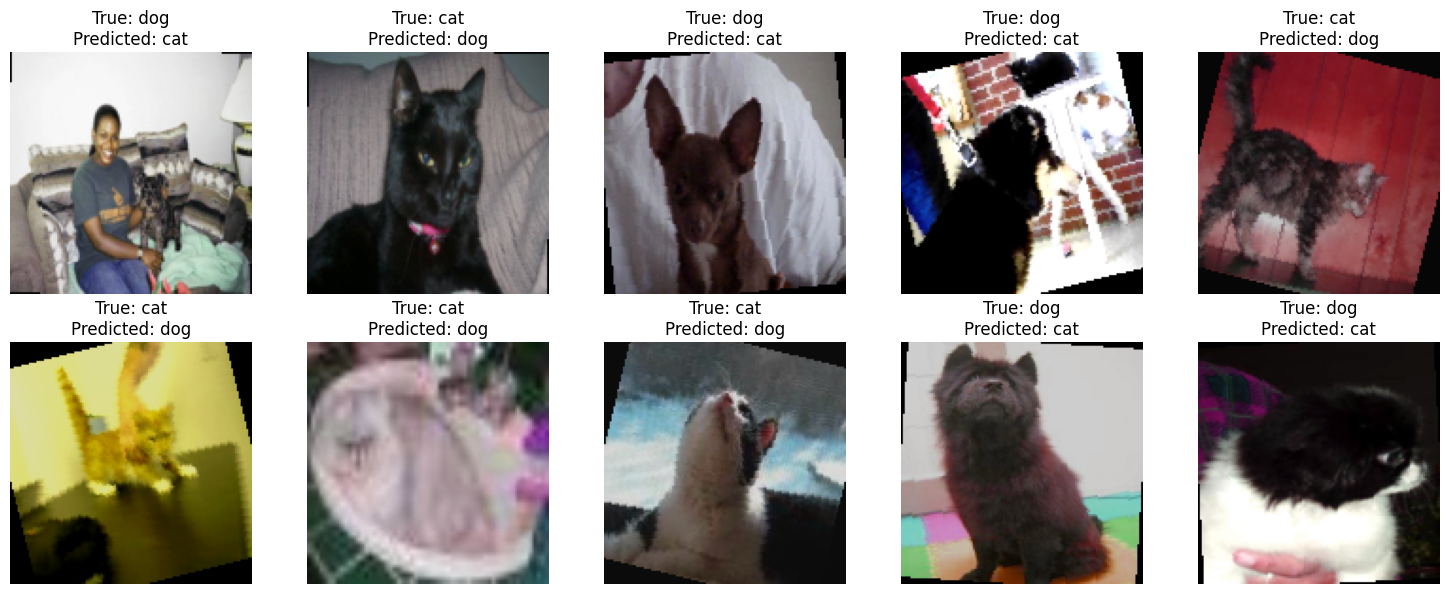

Incorrect predictions saved as incorrect_predictions.png


In [14]:
# Analyze Incorrect Predictions
# Function to plot incorrectly classified images to help understand model weaknesses
def plot_incorrect_predictions(model, val_loader, num_images=10):
    model.eval()
    incorrect_images = []
    incorrect_labels = []
    incorrect_preds = []

    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc="Finding Incorrect Predictions"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            incorrect_indices = (preds != labels).nonzero(as_tuple=True)[0]
            
            for idx in incorrect_indices:
                if len(incorrect_images) >= num_images:
                    break
                incorrect_images.append(inputs[idx].cpu())
                incorrect_labels.append(labels[idx].item())
                incorrect_preds.append(preds[idx].item())

    # Plotting incorrect predictions
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.flatten()
    for i in range(len(incorrect_images)):
        image = incorrect_images[i].permute(1, 2, 0).numpy() * 0.5 + 0.5  # Reverse normalization
        image = np.clip(image, 0, 1)
        true_label = 'cat' if incorrect_labels[i] == 0 else 'dog'
        predicted_label = 'cat' if incorrect_preds[i] == 0 else 'dog'
        axes[i].imshow(image)
        axes[i].set_title(f"True: {true_label}\nPredicted: {predicted_label}")
        axes[i].axis('off')
    plt.tight_layout()
    plt.savefig('figures/incorrect_predictions.png')
    plt.show()
    print('Incorrect predictions saved as incorrect_predictions.png')

# Call the function to visualize incorrect predictions
plot_incorrect_predictions(model, test_loader)

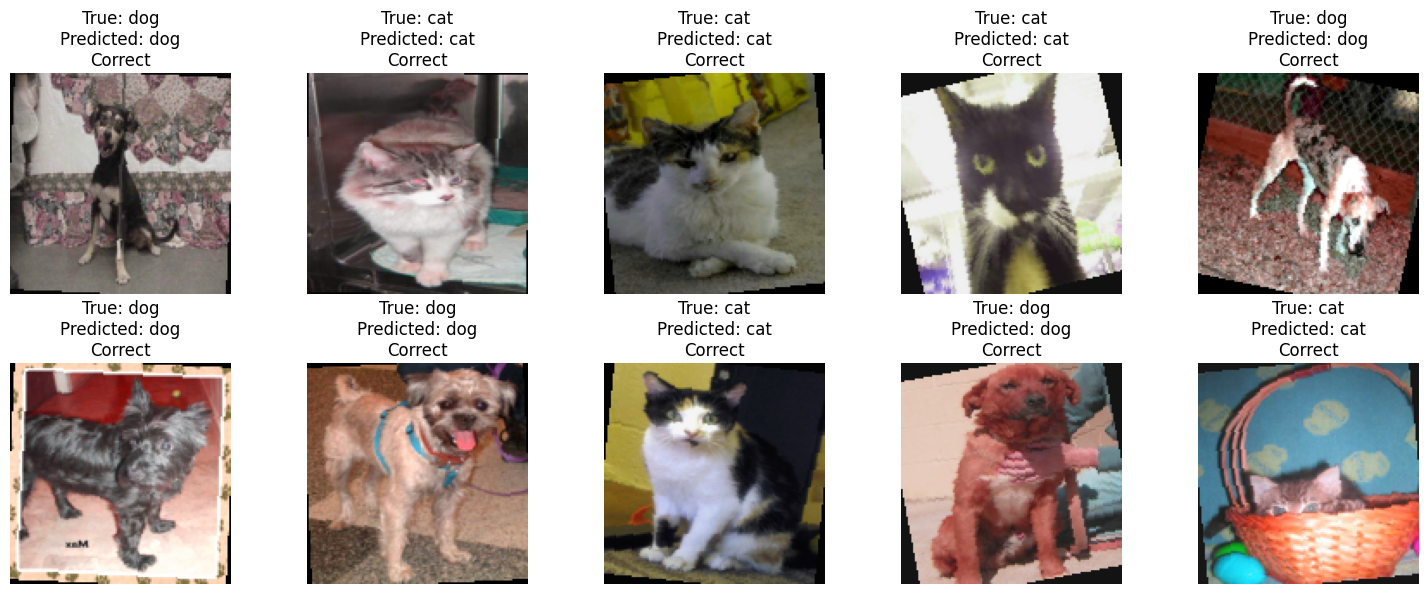

Correct Predictions: 10/10
Incorrect Predictions: 0/10


In [15]:
# Test the Model on Sample Images
# Evaluate the model's performance on randomly selected images from the validation set
def test_model_on_validation_samples(model, val_dataset, num_samples=10):
    model.eval()
    sample_indices = random.sample(range(len(val_dataset)), num_samples)
    correct_predictions = 0
    incorrect_predictions = 0
    results = []

    # Iterate over the selected images
    for idx in sample_indices:
        image, label = val_dataset[idx]
        image_tensor = image.unsqueeze(0).to(device)
        with torch.no_grad():
            output = model(image_tensor)
            _, predicted = torch.max(output, 1)
            predicted_label = 'cat' if predicted.item() == 0 else 'dog'
            true_label = 'cat' if label == 0 else 'dog'
            success = (predicted_label == true_label)
            if success:
                correct_predictions += 1
            else:
                incorrect_predictions += 1
            results.append((image, true_label, predicted_label, success))

    # Plotting results in a matrix format
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.flatten()
    for i, (image, true_label, predicted_label, success) in enumerate(results):
        image = image.permute(1, 2, 0).numpy() * 0.5 + 0.5  # Reverse normalization
        image = np.clip(image, 0, 1)
        axes[i].imshow(image)
        axes[i].set_title(f"True: {true_label}\nPredicted: {predicted_label}\n{'Correct' if success else 'Incorrect'}")
        axes[i].axis('off')
    plt.tight_layout()
    plt.savefig('figures/validation_predictions_A.png')
    plt.show()

    # Summary of results
    print(f"Correct Predictions: {correct_predictions}/{num_samples}")
    print(f"Incorrect Predictions: {incorrect_predictions}/{num_samples}")

# Test the model on some sample validation images
test_model_on_validation_samples(model, test_dataset, num_samples=10)